# Introduction
This project presents an automated document scanning system that captures, rectifies, and enhances document images using computer vision techniques. A companion [video](https://youtu.be/sTGh5_ssfv0) demonstrates the complete workflow and real-world results. The pipeline includes edge detection, perspective correction, and optional binarization to produce scanner-like results from smartphone photos.

# Import libraries


In [1]:
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

# Processing the image
This code performs edge detection on an image through a multi-step pipeline. First, it loads and resizes the input image (`test_img.jpg`) to 20% of its original dimensions to reduce processing time. The image is then converted to grayscale and smoothed using a Gaussian blur to eliminate noise. Finally, the **Canny** edge detection algorithm identifies edges using threshold values of 50 (weak edges) and 200 (strong edges), producing a binary image where white pixels represent detected edges. 

The code displays both the resized original image and the edge detection results side-by-side for comparison, with proper color space conversion from OpenCV's BGR format to matplotlib's RGB format for accurate visualization.

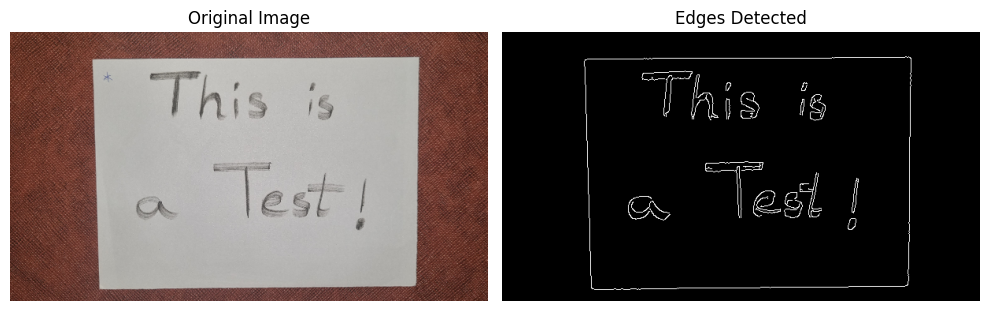

In [ ]:
# load in the image
img_name = "test_img.jpg"  # this part can be replaced by any name/path of an image
image = cv2.imread(img_name)
orig = image.copy()

# resize the image
height = image.shape[0]
width = image.shape[1]
ratio = 0.2
width = int(ratio * width)
height = int(ratio * height)
image = cv2.resize(image, (width, height))

# find edges in the image
gray_scaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# blur the image using Gaussian blur
gray_scaled = cv2.GaussianBlur(gray_scaled, (5, 5), 0)

# edge detection
edged = cv2.Canny(gray_scaled, 50, 200)

# convert BGR to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# display the images using matplotlib
plt.figure(figsize=(10, 5))

# show original image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# how edge detected image
plt.subplot(1, 2, 2)
plt.imshow(edged, cmap='gray')
plt.title("Edges Detected")
plt.axis('off')

plt.tight_layout()
plt.show()

# Contour Detection and Filtering
This code identifies and filters contours from the edge-detected image. Using OpenCV's `findContours` function, it detects all possible contours in the binary edge map (`RETR_LIST` mode) with simplified point representation (`CHAIN_APPROX_SIMPLE`). The `imutils.grab_contours` function ensures version compatibility by extracting contours consistently across different OpenCV versions. The code then sorts all detected contours by area in descending order and keeps only the **5 largest contours**, effectively filtering out smaller, potentially noisy shapes while preserving the most significant structural elements of the image.

In [3]:
# detect all contours in the edge-detected image
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# handle OpenCV version compatibility 
contours = imutils.grab_contours(contours)

# sort contours by area (descending) and keep top 5 largest contours which filters out small noise while preserving major shapes
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

# Document Contour Detection
This code processes potential contours to identify a document boundary within the image. For each contour, it first calculates the perimeter length, then applies the Douglas-Peucker algorithm to simplify the contour shape with a tolerance of 2% of the perimeter length. The logic specifically looks for quadrilateral shapes (4-vertex contours), assuming these likely represent documents in the image. When a 4-sided contour is found, it's stored as the detected document outline and the search terminates, prioritizing efficiency. This approach effectively filters for the most probable document shape while accommodating minor imperfections in edge detection through the approximation tolerance.

In [4]:
# process each contour to find document edges
for contour in contours:
    # calculate contour perimeter (closed curve)
    perimeter = cv2.arcLength(contour, True)
    
    # simplify contour shape using Douglas-Peucker algorithm
    approximation = cv2.approxPolyDP(contour, 0.02*perimeter, True)
    
    # if contour has 4 vertices, assume it's the document (most documents are rectangular/quads)
    if len(approximation) == 4:
        paper_outline = approximation
        break  # stop after finding first valid document contour

# Document Outline Visualization

This code visualizes the detected document contour by:

1. **Drawing the contour**:
   - Creates a copy of the original image to preserve data
   - Draws the 4-point `paper_outline` contour in blue (BGR color (225, 0, 0))
   - Uses 2px line thickness for clear visibility

2. **Displaying the result**:
   - Converts from OpenCV's BGR format to RGB for proper color display
   - Shows the image with matplotlib for inline notebook viewing
   - Removes axes for cleaner presentation
   - Includes a descriptive title

The blue quadrilateral contour represents the algorithm's identification of the document boundaries in the image. This visualization helps verify the accuracy of the edge detection and contour approximation steps.

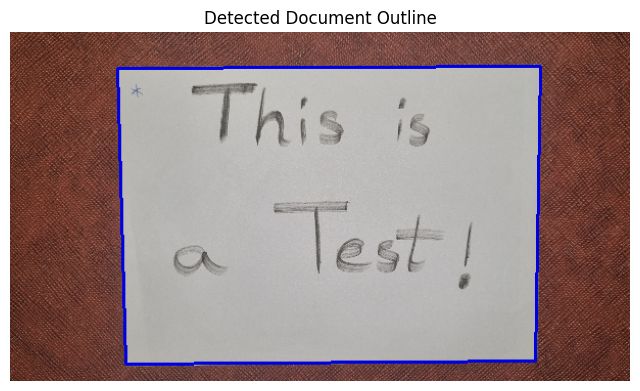

In [ ]:
# draw the detected document contour on original image
output = image.copy()
cv2.drawContours(output, [paper_outline], -1, (225, 0, 0), 2)  # Blue contour, 2px thickness

# convert BGR to RGB for proper matplotlib display
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# display result below cell
plt.figure(figsize=(8,6))
plt.imshow(output_rgb)
plt.title("Detected Document Outline", fontsize=12)
plt.axis('off')
plt.show()

# Point Arrangement Algorithm

This function organizes 4 unordered 2D points into a consistent order representing a quadrilateral's corners:

1. **Initialization**:
   - Creates a 4x2 array to store ordered points (top-left, top-right, bottom-right, bottom-left)

2. **Sum-based ordering**:
   - Calculates the sum of x+y coordinates for each point
   - Top-left point: smallest sum (closest to origin)
   - Bottom-right point: largest sum (farthest from origin)

3. **Difference-based ordering**:
   - Calculates the difference (x-y) for remaining points
   - Top-right point: smallest difference (x ≈ y)
   - Bottom-left point: largest difference (x ≠ y)

4. **Visual verification**:
   - The test plot shows original (red) vs ordered (blue) points
   - Labels each corner with position (tl, tr, br, bl)
   - Demonstrates the consistent ordering regardless of input sequence

**Key Applications**:
- Document scanning (consistent corner ordering for perspective transform)
- Computer vision tasks requiring ordered quadrilateral points
- Geometry processing where point sequence matters

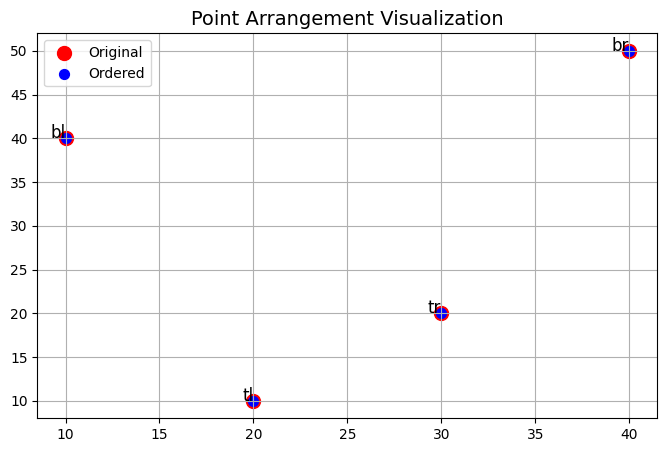

In [ ]:
def arrange_points(points):
    # initialize 4x2 array to store ordered points (tl, tr, br, bl)
    rectangle = np.zeros((4, 2), dtype="float32")
    
    # sum of x+y coordinates: 
    # - top-left has smallest sum (closest to origin)
    # - bottom-right has largest sum (farthest from origin)
    sum_points = points.sum(axis=1)
    rectangle[0] = points[np.argmin(sum_points)]  # top-left
    rectangle[2] = points[np.argmax(sum_points)]  # bottom-right
    
    # difference between x-y coordinates:
    # - top-right has smallest difference (x ≈ y)
    # - bottom-left has largest difference (x ≠ y)
    diff_points = np.diff(points, axis=1)
    rectangle[1] = points[np.argmin(diff_points)]  # top-right
    rectangle[3] = points[np.argmax(diff_points)]  # bottom-left
    
    return rectangle

# visualization test (add below the function)
test_points = np.array([[30, 20], [10, 40], [40, 50], [20, 10]])
ordered = arrange_points(test_points)

plt.figure(figsize=(8, 5))
plt.scatter(test_points[:,0], test_points[:,1], c='red', s=100, label='Original')
plt.scatter(ordered[:,0], ordered[:,1], c='blue', s=50, label='Ordered')
for i, (x, y) in enumerate(ordered):
    plt.text(x, y, f"{['tl','tr','br','bl'][i]}", fontsize=12, ha='right')
plt.legend()
plt.title("Point Arrangement Visualization", fontsize=14)
plt.grid(True)
plt.show()

# Perspective Correction Transformation

This function performs a perspective correction on an image using four detected corner points:

1. **Point Organization**:
   - Uses `arrange_points()` to consistently order the input points (top-left, top-right, bottom-right, bottom-left)
   - Calculates actual dimensions of each side using Euclidean distance between points

2. **Output Dimensions Calculation**:
   - Determines maximum height from left and right sides
   - Determines maximum width from top and bottom sides
   - Creates a destination rectangle with these dimensions

3. **Perspective Transformation**:
   - Computes a perspective transform matrix mapping original points to destination rectangle
   - Applies the transformation using `warpPerspective`
   - Returns the corrected (warped) image

4. **Visual Verification**:
   - Left panel shows original image with detected corners labeled
   - Right panel shows perspective-corrected result
   - Labels each corner point (TL, TR, BR, BL) for validation

**Key Features**:
- Handles quadrilateral shapes of any orientation
- Maintains aspect ratio based on actual detected dimensions
- Includes visual debugging to verify corner detection
- Returns a rectangular output regardless of input perspective

**Mathematical Basis**:
- Uses Euclidean distance: `√((x₂-x₁)² + (y₂-y₁)²)` for dimension calculation
- Perspective transform solves the homography between two planes
- Preserves straight lines while correcting perspective distortion

In [ ]:
def set_four_points(image, points):
    # order points consistently (tl, tr, br, bl)
    rectangle = arrange_points(points)
    (top_left, top_right, bottom_right, bottom_left) = rectangle
    
    # calculate dimensions of quadrilateral sides using Euclidean distance
    left_height = np.sqrt(((top_left[0]-bottom_left[0])**2) + ((top_left[1]-bottom_left[1])**2))
    right_height = np.sqrt(((top_right[0]-bottom_right[0])**2) + ((top_right[1]-bottom_right[1])**2))
    top_width = np.sqrt(((top_right[0]-top_left[0])**2) + ((top_right[1]-top_left[1])**2))
    bottom_width = np.sqrt(((bottom_right[0]-bottom_left[0])**2) + ((bottom_right[1]-bottom_left[1])**2))
    
    # determine output dimensions (maximum height and width)
    maxheight = max(int(left_height), int(right_height))
    maxwidth = max(int(top_width), int(bottom_width))
    
    # define destination points for perspective transform
    destination = np.array([
        [0, 0],                      # Top-left
        [maxwidth-1, 0],             # Top-right
        [maxwidth-1, maxheight-1],   # Bottom-right
        [0, maxheight-1]],           # Bottom-left
        dtype="float32")
    
    # compute perspective transform and apply it
    matrix = cv2.getPerspectiveTransform(rectangle, destination)
    warped = cv2.warpPerspective(image, matrix, (maxwidth, maxheight))
    
    # visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", fontsize=10)
    for i, (x, y) in enumerate(rectangle):
        plt.scatter(x, y, c='red', s=50)
        plt.text(x, y, f"{['TL','TR','BR','BL'][i]}", fontsize=12, color='white')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return warped

# Document Scanning Results

This code completes the document scanning pipeline:

1. **Perspective Correction**:
   - Applies the `set_four_points` function using the detected document corners
   - Multiplies points by `1/ratio` to scale back to original image dimensions
   - Produces a flat, rectangular view of the document

2. **Optional Processing** (currently commented out):
   - Converts to grayscale for document processing
   - Applies adaptive thresholding using:
     - 11x11 pixel neighborhood
     - Gaussian weighting method
     - 10 intensity offset
   - Creates a binary (black-and-white) document representation

3. **Results Visualization**:
   - Shows side-by-side comparison:
     - Left: Original image (resized for display)
     - Right: Corrected "scanned" output
   - Uses consistent sizing for fair comparison
   - Maintains proper color space conversion (BGR→RGB)

**Key Observations**:
- The perspective correction should produce a clean rectangular output
- Resizing maintains aspect ratio for display purposes
- Uncomment thresholding steps for better document readability
- White borders may appear if the original capture wasn't perfectly aligned

**Next Steps**:
1. Uncomment thresholding for document binarization
2. Adjust threshold parameters for optimal text clarity
3. Add post-processing (deskew, contrast enhancement)

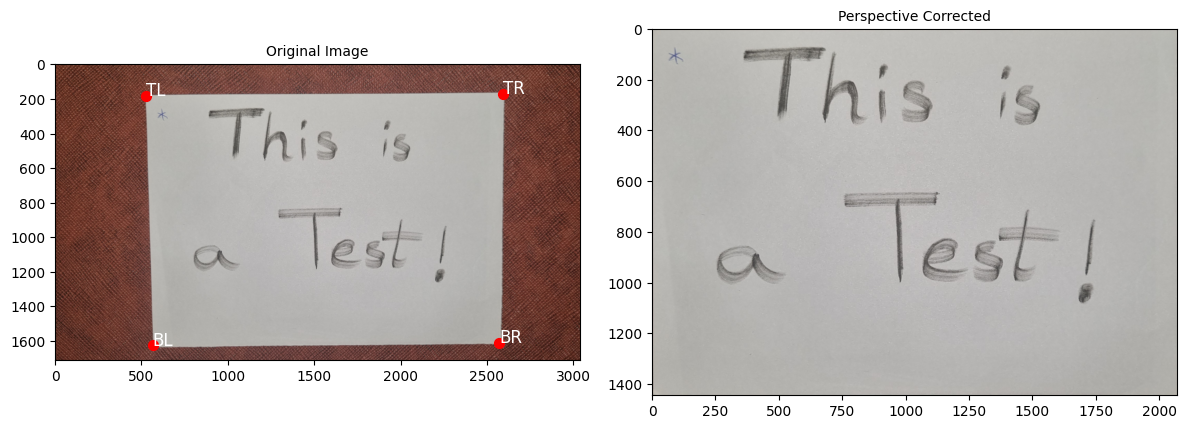

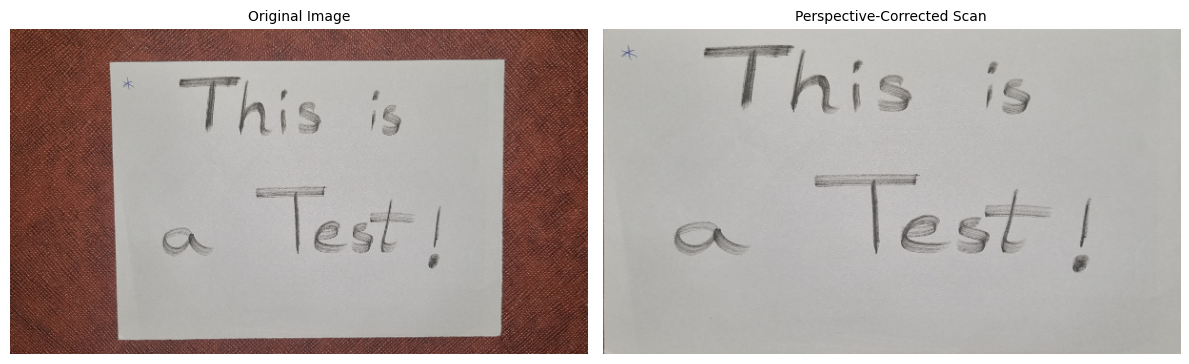

Scan saved as scanned_document_20250325_233037.png in current directory


In [ ]:
SAVE_SCAN = True  # Set to False to disable saving

# apply perspective correction using the detected document contour
warped = set_four_points(orig, paper_outline.reshape(4,2)*(1/ratio))

# display comparison using matplotlib for better inline visualization
plt.figure(figsize=(12, 6))

# original image (resized)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.resize(orig, (width, height)), cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=10)
plt.axis('off')

# scanned result (resized)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.resize(warped, (width, height)), cv2.COLOR_BGR2RGB))
plt.title("Perspective-Corrected Scan", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

# save functionality
if SAVE_SCAN:
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"scanned_document_{timestamp}.png"
    

    cv2.imwrite(filename, cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))
    print(f"Scan saved as {filename} in current directory")
else:
    print("Scan not saved (SAVE_SCAN=False)")